# Modèles basés sur des arbres en classifieurs faibles :PARTIE 2

Objectif 1: comparer les performances des mêmes modèles, avec et sans recalibrage Borderline SMOTE et ADASYN.
Objectif 2 : tuner pas-à-pas les mêmes modèles plus performants
   
## Afin de comparer l'impact du recalibrage, protocole en 3 étapes : (1) sans recalibrage (2) avec Borderline SMOTE (3) avec ADASYN


# Le meilleur modèle obtenu est une forêt aléatoire sur Adasyn se basant principalement sur exactement les mêmes variables principales que XGBoost avec SMOTE (cf. PARTIE 1) : FP2, D2CB,FP3.
   

**(1) Importation des librairies**

In [1]:
import os
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import sys 
import fastparquet
import dask_ml 
from dask import delayed
from sklearn.metrics import *
import scikitplot as skplt
from dask_ml.preprocessing import StandardScaler
import pickle

**(2) Import des algorithmes random forest, adaboost, Extrême Gradient Boosting**

**random forest** :  plusieurs arbres sont créés et chaque arbre est formé sur un échantillon du jeu d’entraînement avec bagging.

**adaboost** : avantages (1) simple d'utilisation (2) convergence de l'erreur d'entraînement / faible risque de sur-apprentissage. Principe : repose sur la sélection itérative du classifieur faible (un arbre) en fonction d'une distribution des exemples d'apprentissage. Chaque exemple est pondéré en fonction de sa difficulté avec le classifieur courant.

**XGBoost(extreme gradient boosting)** : Cette méthode repose sur les arbres de décision et s'améliore à partir d'autres méthodes telles que la forêt aléatoire. Elle est efficace avec les jeux de données volumineux et complexes en faisant appel à diverses méthodes d'optimisation. 

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

import dask
import dask
import xgboost
import dask_xgboost

C:\Users\chrys\anaconda3\lib\site-packages\dask_xgboost\__init__.py:7: UserWarning: Dask-XGBoost has been deprecated and is no longer maintained. The functionality of this project has been included directly in XGBoost. To use Dask and XGBoost together, please use ``xgboost.dask`` instead https://xgboost.readthedocs.io/en/latest/tutorials/dask.html.
  warnings.warn(


In [3]:
#pip install dask.ml

In [4]:
#pip install scikit-plot

## ETAPE 1 : PAS DE RECALIBRAGE

# I. Préparation 

**(1) variables explicatives, variable à prédire et centrage-réduction**

In [5]:
import os
os.chdir("C:/Fouille-donnees-massives")

In [6]:
# Dataframe d’apprentissage sans recalibrage
df_train = dd.read_parquet("train_fast")
df_train.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 13 entries, FlagImpaye to Heure_num
dtypes: float64(7), int64(6)

In [7]:
# Dataframe de test
df_test = dd.read_parquet("test_fast")
df_test.head()

,FlagImpaye,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR,Heure_num
3899362,0,60.00,0,302,0.000000,0.000000,0.000000,52.076034,0,1,4.000000,0.00,7
3899363,0,25.00,0,547,0.000000,0.000000,0.000000,52.076034,0,1,4.000000,0.00,8
3899364,0,32.00,0,152,0.000000,0.000000,0.000000,52.076034,0,1,4.000000,0.00,8
3899365,0,20.88,0,393,0.007590,0.182221,0.002092,34.118277,4,1,1.539155,71.51,8
3899366,0,20.21,0,152,0.018994,-1.024399,0.005682,52.076034,0,1,4.000000,0.00,8


In [8]:
# Définir les variables explicatives et la variable cible 
X_train = df_train.drop(["FlagImpaye"], axis = "columns")
X_test = df_test.drop(["FlagImpaye"], axis = "columns")

y_train = df_train["FlagImpaye"]
y_test = df_test["FlagImpaye"]

In [9]:
X_train.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 12 entries, Montant to Heure_num
dtypes: float64(7), int64(5)

In [10]:
# Instanciation de StandardScaler pour centrer-réduire les données
scaler = StandardScaler()

In [11]:
# Centrer-réduire le dataframe d'apprentissage
X_train = scaler.fit_transform(X_train)
X_train.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR,Heure_num
0,-0.420302,-0.581824,1.017656,-0.084590,-0.239505,-0.275801,0.818043,-0.043817,-0.194165,-0.451325,-0.202861,-2.122399
1,-0.420302,-0.581824,1.017656,-0.084590,-0.239505,-0.275801,0.818043,-0.043812,4.975724,-0.451325,0.038808,-2.122399
2,-0.022127,-0.581824,1.008573,-0.084590,-0.239505,-0.275801,0.818043,-0.043817,-0.194165,-0.451325,-0.202861,-2.122399
3,-0.057565,1.545332,-0.272152,-0.084590,-0.239505,-0.275801,0.906727,-0.043817,-0.194165,-0.451325,-0.202861,-2.122399
4,-0.347310,-0.581824,1.008573,-0.084434,0.637044,-0.273204,0.818043,-0.043812,-0.194165,-0.451325,0.702346,-1.820898


In [12]:
# Centrer-réduire les dataframe de test
X_test = scaler.fit_transform(X_test)
X_test.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR,Heure_num
3899362,-0.016999,0.0,0.265719,-0.080269,-0.043960,-0.317899,0.774799,-0.036921,-0.18432,-0.568544,-0.132257,-2.235916
3899363,-0.277531,0.0,1.427785,-0.080269,-0.043960,-0.317899,0.774799,-0.036921,-0.18432,-0.568544,-0.132257,-1.929154
3899364,-0.225425,0.0,-0.445750,-0.080269,-0.043960,-0.317899,0.774799,-0.036921,-0.18432,-0.568544,-0.132257,-1.929154
3899365,-0.308200,0.0,0.697344,-0.080074,-0.023966,-0.314458,-0.277090,-0.036897,-0.18432,-5.906429,1.259186,-1.929154
3899366,-0.313187,0.0,-0.445750,-0.079781,-0.156360,-0.308551,0.774799,-0.036921,-0.18432,-0.568544,-0.132257,-1.929154


**(2) Maximisation de la marge**

In [13]:
def perte(Montant):
    if Montant<=20:
        Montant=Montant*0
    elif 20<Montant<=50:
        Montant=0.2*Montant
    elif 50<Montant<=100:
        Montant=0.3*Montant
    elif 100<Montant<=200:
        Montant=0.5*Montant
    elif Montant>200:
        Montant=0.8*Montant
    return(Montant)

In [14]:
def Calcul_Marge(Montant, yReel, yPred):
    # Création de dfmerge
    dfmerge = pd.concat([Montant, yReel], axis=1)
    dfmerge["Ypred"] = yPred
    
    # Création de la variable Marge
    # Création d'une colonne Marge égale au Montant
    dfmerge["Marge"] = dfmerge["Montant"]
    #Calcul du gain ou de la perte selon la différence entre réel et prédiction
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 1)), "Marge"] = 0
    dfmerge.loc[((dfmerge["FlagImpaye"] == 0) & (dfmerge["Ypred"] == 1)), "Marge"] = 0.7 * 0.05 * dfmerge["Montant"]
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 0)), "Marge"] = dfmerge["Montant"].apply(lambda x: -perte(x))
    dfmerge.loc[((dfmerge["FlagImpaye"] == 0) & (dfmerge["Ypred"] == 0)), "Marge"] = 0.05 * dfmerge["Montant"]
    
    # Calcul du Marge_totale
    Marge_totale = dfmerge["Marge"].sum()
    
    return Marge_totale

**(3) Modèles et performances**

In [15]:
# Fonction de déploiement d'un modèle sur les données de test

# Création de la fonction de performance d'un modèle sur les données de test

def performances(modele, X_test, y_test, scale):
    
    X_test_ = X_test
    
    print("-------------------------------------------------------")
   
    
    if scale == True:
        X_test = scaler.transform(X_test) # scaler a été entrainé sur les données d'apprentissage
        
    # Affichage du modèle 
    print('Modèle :\n', modele)
    print("-------------------------------------------------------")
    # Prédiction
    y_pred = delayed(modele.predict)(X_test).compute()
    # Prédiction des scores
    y_score = delayed(modele.predict_proba)(X_test).compute()
    
    # Estimateurs, matrice de confusion et AUC
    cm = delayed(confusion_matrix)(y_test, y_pred).compute()
    cr = delayed(classification_report)(y_test, y_pred).compute()
    auc = delayed(roc_auc_score)(y_test, y_pred).compute()
    f1 = delayed(f1_score)(y_test, y_pred).compute()
   
    print('F1_score :\n', f1)
    print("-------------------------------------------------------")
    print('Estimateurs :\n', cr)
    print("-------------------------------------------------------")
    print('Matrice de confusion :\n', cm)
    print("-------------------------------------------------------")
    print('Auc Score :\n', auc)
    print("-------------------------------------------------------")
    
    #Calcul de la Marge
    Marge_totale = Calcul_Marge(Montant = X_test_["Montant"].compute(), yReel = y_test.compute(), yPred = y_pred)
    print("Marge = " + str(round(Marge_totale, 2)) + " euros")
    
    print("-------------------------------------------------------")
    
    # Courbe ROC
    skplt.metrics.plot_roc(y_test, y_score, classes_to_plot = 1, plot_micro = False, plot_macro = False)
    # Courbe Précision-Rappel
    skplt.metrics.plot_precision_recall(y_test, y_score, classes_to_plot = 1, plot_micro = False)

    #return y_score,Marge_totale,auc,cr,cm

Si la courbe ROC tient la route avec un critère AUC élevé, cela signifie que l'apprentissage a bien fonctionné Si le F1_score est très mauvais, cela signifie alors que c'est le processus d'affectation qui n'a pas fonctionné.

# II. Algorithmes

# A. Random forest

GridSearch n'a pu être implémenté en raison des temps de traitement (tentative : pas de sortie au bout de 5h).

In [16]:
#Instanciation # 10 arbres #paramètres par défaut : indice de Gini (log_loss) #Bootstrap = True (par défaut)
#random_state= 0 (par défaut) déjà testé - 42 : le plus souvent utilisé avec "0"

RandomForest = RandomForestClassifier(n_estimators = 10, random_state = 0)

# Fit your pipeline onto your training set (centré-réduit) and obtain predictions by fitting the model onto the test data
%time classifier1 = delayed(RandomForest.fit)(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


-------------------------------------------------------
Modèle :
 Delayed('fit-fed280a9-8fdb-40e4-87cb-566b311a8e4a')
-------------------------------------------------------
F1_score :
 0.0003038128512836093
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    740837
           1       0.10      0.00      0.00      6573

    accuracy                           0.99    747410
   macro avg       0.55      0.50      0.50    747410
weighted avg       0.98      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[740828      9]
 [  6572      1]]
-------------------------------------------------------
Auc Score :
 0.5000699945555083
-------------------------------------------------------
Marge = -99.71 euros
-------------------------------------------------------
CPU times: total: 7min 15s
Wall time: 7min 16s


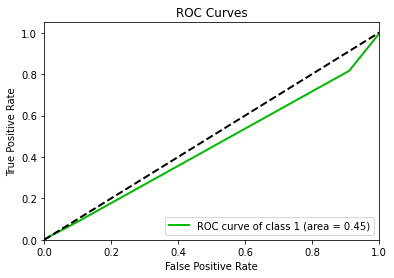

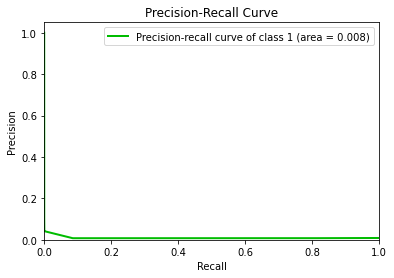

In [17]:
%time performances(classifier1, X_test, y_test,scale=True)

In [18]:
#dir(RandomForest)

**Différences avec le même modèle avec BorderlineSMOTE :**

-Montant en caractéristique principale du modèle (vs Taux chèques impayés)

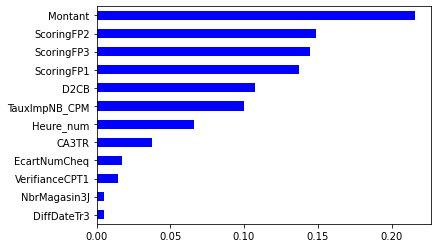

In [19]:
importances = pd.Series(RandomForest.feature_importances_, index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances.plot(kind='barh', color='blue')
plt.show()

**(1) Le modèle n'est pas très bon. Ex.Marge = -99.71€ -> Tuning : on teste le bagging pour réduire l'instabilité**

In [20]:
from sklearn.ensemble import BaggingClassifier
#from sklearn.model_selection import GridSearchCV # annulé pour cause de durée de traitement

In [21]:
#avec bagging 
model_best= RandomForestClassifier(n_estimators = 10, random_state = 0)

modele_best =BaggingClassifier(base_estimator=model_best,n_estimators = 10, random_state = 0,n_jobs=-1)

In [22]:
# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data
%time classifierb = delayed(model_best.fit)(X_train, y_train).compute()

CPU times: total: 3min 24s
Wall time: 3min 24s


-------------------------------------------------------
Modèle :
 RandomForestClassifier(n_estimators=10, random_state=0)
-------------------------------------------------------
F1_score :
 0.0003038128512836093
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    740837
           1       0.10      0.00      0.00      6573

    accuracy                           0.99    747410
   macro avg       0.55      0.50      0.50    747410
weighted avg       0.98      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[740828      9]
 [  6572      1]]
-------------------------------------------------------
Auc Score :
 0.5000699945555083
-------------------------------------------------------
Marge = -99.71 euros
-------------------------------------------------------
CPU times: total: 8 s
Wall time: 7.07 s


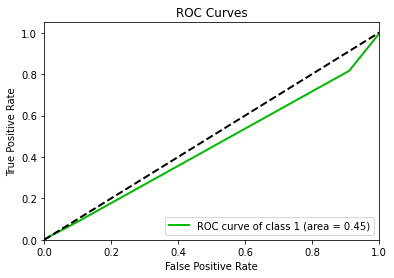

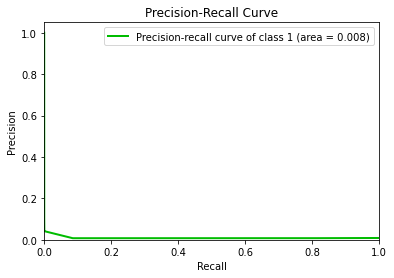

In [23]:
%time performances(classifierb, X_test, y_test,scale=True)

**Pas de différence avec et sans bagging, hormis en terme de temps (bagging, moins long) : nous réaliserons directement les RF avec bagging pour les prochaines étapes.**

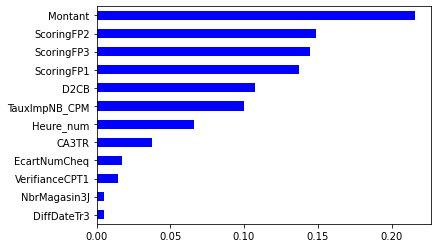

In [24]:
importances = pd.Series(model_best.feature_importances_, index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances.plot(kind='barh', color='blue')
plt.show()

# B. Adaboost

In [25]:
# Instanciation avec les mêmes paramètres
dtree = DecisionTreeClassifier(random_state = 0)

AdaBoost = AdaBoostClassifier(base_estimator = dtree, random_state = 0, n_estimators = 10)

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data
%time classifier2 = delayed(AdaBoost.fit)(X_train, y_train).compute()

CPU times: total: 9min 54s
Wall time: 9min 54s


-------------------------------------------------------
Modèle :
 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                   n_estimators=10, random_state=0)
-------------------------------------------------------
F1_score :
 0.0003003453972067878
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    740837
           1       0.01      0.00      0.00      6573

    accuracy                           0.99    747410
   macro avg       0.50      0.50      0.50    747410
weighted avg       0.98      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[740752     85]
 [  6572      1]]
-------------------------------------------------------
Auc Score :
 0.500018701221077
-------------------------------------------------------
Marge = -121.1 euros
-----------------------------------------

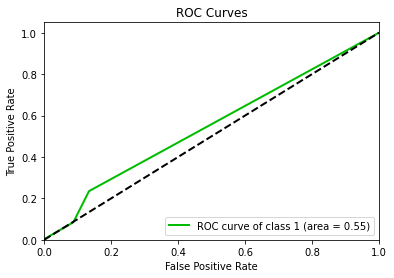

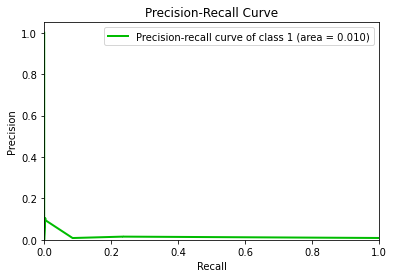

In [26]:
%time performances(classifier2, X_test, y_test,scale=True)

**Différences avec le même modèle avec BorderlineSMOTE :**

-3 variables importantes (Scoring P2 +FP1+VerifianceCPT1) vs DiffDateTr3

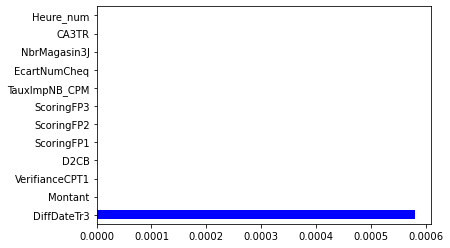

In [27]:
importances = pd.Series(AdaBoost.feature_importances_, index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances.plot(kind='barh', color='blue')
plt.show()

# C. XGradient boosting

In [28]:
# En pratique, ces arbres sont peu profonds, nous conservons le paramètre par défaut =3

from xgboost import XGBClassifier 

dtree = DecisionTreeClassifier(max_depth = 3, random_state = 0)

modele = XGBClassifier(base_estimator = dtree, n_estimators = 10, random_state = 0) 
# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data
%time classifier3 = delayed(modele.fit)(X_train, y_train).compute()

CPU times: total: 47.9 s
Wall time: 48.8 s


-------------------------------------------------------
Modèle :
 XGBClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                    random_state=0),
              n_estimators=10)
-------------------------------------------------------


C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1_score :
 0.0
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    740837
           1       0.00      0.00      0.00      6573

    accuracy                           0.99    747410
   macro avg       0.50      0.50      0.50    747410
weighted avg       0.98      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[740837      0]
 [  6573      0]]
-------------------------------------------------------
Auc Score :
 0.5
-------------------------------------------------------
Marge = -98.31 euros
-------------------------------------------------------
CPU times: total: 8.02 s
Wall time: 7.13 s


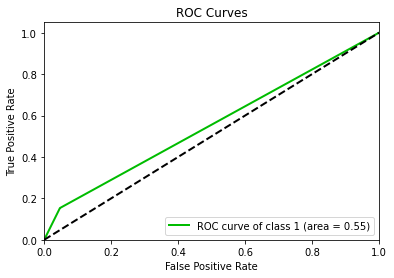

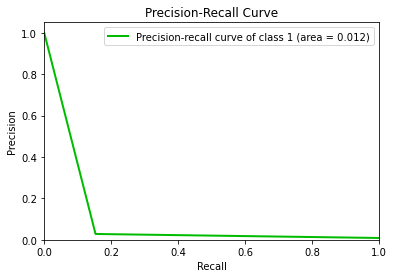

In [29]:
%time performances(classifier3, X_test, y_test,scale=True)

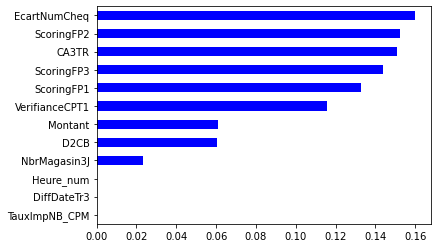

In [30]:
importances = pd.Series(modele.feature_importances_, index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances.plot(kind='barh', color='blue')
plt.show()

**Conclusions et décisions pour la suite du protocole**

Tous les modèles génèrent une marge négative d'autour 100€. 

De plus, Adaboost obtient les plus mauvaises performances en matière de marge négative (-121.10€) et de temps de traitement (10 minutes vs ~ 7 minutes pour la forêt aléatoire, vs moins de 1 minute pour XGBoost). Dans la mesure cependant où cette durée reste raisonnable, nous allons regarder si Adaboost fonctionne mieux sur un échantillon recalibré avec Borderline SMOTE en matière de capacités prédictives -avant de l'évacuer définitivement si ce n'est pas le cas. 

Le bagging produit les mêmes résultats que la forêt aléatoire seule (qui inclut déjà un boostrap par défaut), sauf qu'il produit un temps de calcul 2 fois plus court (3'31 vs 7'16) : nous intégrons directement le bagging dans la forête aléatoire pour la suite des opérations. 

## ETAPE 2 : RECALIBRAGE AVEC Borderline SMOTE

 (augmentation de la classe minoritaire à 50%). Paramètres : k=3 ; m=2.


# I. Préparation

**(1) variables explicatives, variable à prédire et centrage-réduction**

In [31]:
# Dataframe d’apprentissage avec recalibrage BorderlineSmote
df_trainS = dd.read_parquet("train_borderS")
df_trainS.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR,Heure_num,FlagImpaye
0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00,7,0
1,20.00,0,551,0.000000,0.000000,0.000000,52.076034,1,2,4.0,8.61,7,0
2,57.64,0,549,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00,7,0
3,54.29,1,267,0.000000,0.000000,0.000000,53.554234,0,1,4.0,0.00,7,0
4,26.90,0,549,0.003769,8.586333,0.001192,52.076034,1,1,4.0,32.25,8,0


In [32]:
# Définir les variables explicatives et la variable cible du traain 
X_trainS = df_trainS.drop(["FlagImpaye"], axis = "columns")
y_trainS = df_trainS["FlagImpaye"]

In [33]:
# Centrer-réduire le dataframe d'apprentissage
scaler = StandardScaler()
X_trainS = scaler.fit_transform(X_trainS)
X_trainS.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR,Heure_num
0,-0.508308,-0.652070,1.268061,-0.111142,0.089207,-0.258939,0.636088,-0.046934,-0.197496,-0.43399,-0.203012,-2.276771
1,-0.508308,-0.652070,1.268061,-0.111142,0.089207,-0.258939,0.636088,-0.046929,4.572197,-0.43399,-0.090489,-2.276771
2,-0.152912,-0.652070,1.259134,-0.111142,0.089207,-0.258939,0.636088,-0.046934,-0.197496,-0.43399,-0.203012,-2.276771
3,-0.184542,1.130306,0.000459,-0.111142,0.089207,-0.258939,0.725230,-0.046934,-0.197496,-0.43399,-0.203012,-2.276771
4,-0.443158,-0.652070,1.259134,-0.111060,0.885639,-0.257618,0.636088,-0.046929,-0.197496,-0.43399,0.218457,-1.963115


# II. Algorithmes

# A. Random forest avec bagging

In [34]:
#avec bagging 
model_best= RandomForestClassifier(n_estimators = 10, random_state = 0)

modele_best =BaggingClassifier(base_estimator=model_best,n_estimators = 10, random_state = 0,n_jobs=-1)

In [35]:
# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data
%time classifier4 = delayed(model_best.fit)(X_trainS, y_trainS).compute()

CPU times: total: 6min 20s
Wall time: 6min 20s


-------------------------------------------------------
Modèle :
 RandomForestClassifier(n_estimators=10, random_state=0)
-------------------------------------------------------


C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1_score :
 0.0
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    740837
           1       0.00      0.00      0.00      6573

    accuracy                           0.99    747410
   macro avg       0.50      0.50      0.50    747410
weighted avg       0.98      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[740837      0]
 [  6573      0]]
-------------------------------------------------------
Auc Score :
 0.5
-------------------------------------------------------
Marge = -98.31 euros
-------------------------------------------------------
CPU times: total: 7.61 s
Wall time: 6.98 s


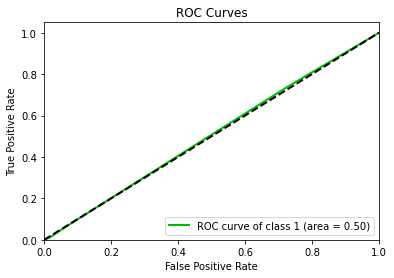

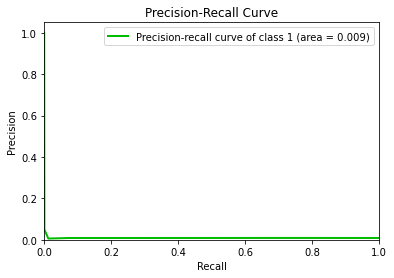

In [36]:
%time performances(classifier4, X_test, y_test,scale=True)

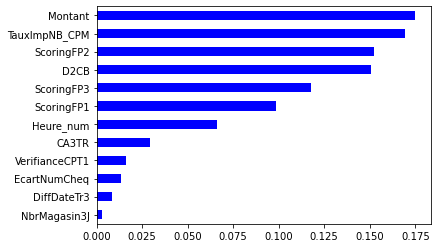

In [37]:
importances = pd.Series(model_best.feature_importances_, index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances.plot(kind='barh', color='blue')
plt.show()

# B. Adaboost

In [38]:
# Instanciation avec les mêmes paramètres pour comparer les perfs
#entre échantillon brut et échantillon recalibré avec BorderlineSmote
dtree = DecisionTreeClassifier(random_state = 0)

AdaBoost = AdaBoostClassifier(base_estimator = dtree, random_state = 0, n_estimators = 10)

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data
%time classifier5 = delayed(AdaBoost.fit)(X_trainS, y_trainS).compute()

CPU times: total: 29min 29s
Wall time: 29min 32s


-------------------------------------------------------
Modèle :
 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                   n_estimators=10, random_state=0)
-------------------------------------------------------
F1_score :
 0.014122456564154975
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    740837
           1       0.01      0.03      0.01      6573

    accuracy                           0.96    747410
   macro avg       0.50      0.50      0.50    747410
weighted avg       0.98      0.96      0.97    747410

-------------------------------------------------------
Matrice de confusion :
 [[715349  25488]
 [  6345    228]]
-------------------------------------------------------
Auc Score :
 0.5001415141068187
-------------------------------------------------------
Marge = -66.34 euros
-----------------------------------------

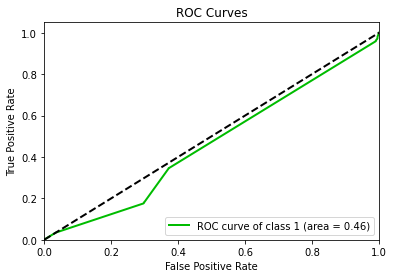

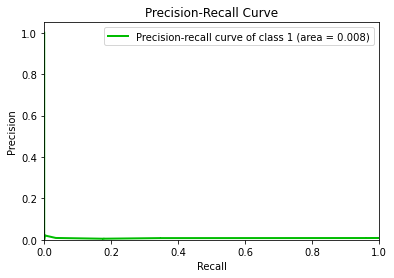

In [39]:
%time performances(classifier5, X_test, y_test,scale=True)

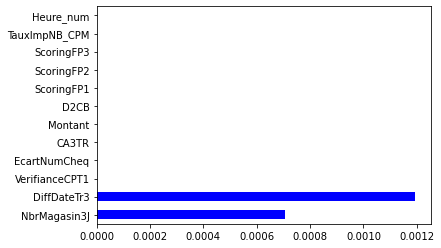

In [40]:
importances = pd.Series(AdaBoost.feature_importances_, index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances.plot(kind='barh', color='blue')
plt.show()

# C. XGradient boosting

In [41]:
# En pratique, ces arbres sont peu profonds. le paramètre par défaut est max_depth=3

from xgboost import XGBClassifier 

dtree = DecisionTreeClassifier(max_depth = 3, random_state = 0)

modele = XGBClassifier(base_estimator = dtree, n_estimators = 10, random_state = 0) 
# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data
%time classifier6 = delayed(modele.fit)(X_trainS, y_trainS).compute()

CPU times: total: 3min 16s
Wall time: 3min 14s


-------------------------------------------------------
Modèle :
 XGBClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                    random_state=0),
              n_estimators=10)
-------------------------------------------------------


C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1_score :
 0.0
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    740837
           1       0.00      0.00      0.00      6573

    accuracy                           0.99    747410
   macro avg       0.50      0.50      0.50    747410
weighted avg       0.98      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[740837      0]
 [  6573      0]]
-------------------------------------------------------
Auc Score :
 0.5
-------------------------------------------------------
Marge = -98.31 euros
-------------------------------------------------------
CPU times: total: 7.06 s
Wall time: 6.39 s


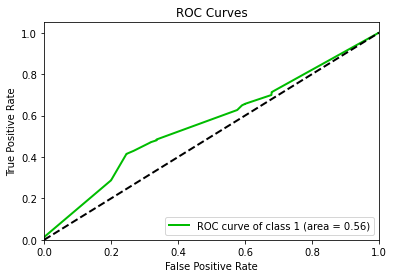

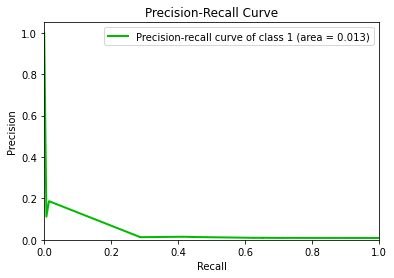

In [42]:
%time performances(classifier6, X_test, y_test,scale=True)

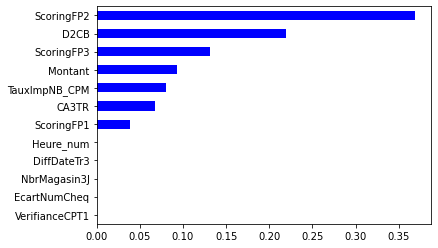

In [43]:
importances = pd.Series(modele.feature_importances_, index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances.plot(kind='barh', color='blue')
plt.show()

**Conclusions et décisions pour la suite du protocole**

Résultats en demi-teinte :
Contrairement à sa performance obtenue sur l'échantillon brut, **Adaboost** génère ici "la meilleure marge" des 3 modèles, bien que celle-ci soit à nouveau négative (-66.34€). LE F1 score est de 1.4%. Cependant, les résultats ont été édités au bout de près de 30 minutes vs moins de 7 min.

XGBoost, modèle le plus rapide, génère le meilleur score AUC avec la forêt aléatoire avec bagging (0.56).

Nous maintenons par conséquent les 3 modèles pour les tester avec l'échantillon d'entraînement Adasyn.

# PARTIE III : RECALIBRAGE AVEC ADASYN

# I. Préparation

In [44]:
# Dataframe d’apprentissage avec recalibrage ADA
df_train = dd.read_parquet("train_ADA")
df_train.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 13 entries, Montant to FlagImpaye
dtypes: float64(7), int64(6)

In [45]:
# Définir les variables explicatives (varaible-cible déjà traitée)
# Définir les variables explicatives et la variable cible du traain 
X_train = df_train.drop(["FlagImpaye"], axis = "columns")
y_train = df_train["FlagImpaye"]

In [46]:
# Centrer-réduire le dataframe d'apprentissage
X_train = scaler.fit_transform(X_train)
X_train.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR,Heure_num
0,-0.517963,-0.633480,1.255333,-0.110650,0.079502,-0.264633,0.637023,-0.044659,-0.183571,-0.453905,-0.200282,-2.292620
1,-0.517963,-0.633480,1.255333,-0.110650,0.079502,-0.264633,0.637023,-0.044654,5.055948,-0.453905,-0.079362,-2.292620
2,-0.158449,-0.633480,1.246433,-0.110650,0.079502,-0.264633,0.637023,-0.044659,-0.183571,-0.453905,-0.200282,-2.292620
3,-0.190446,1.209886,-0.008349,-0.110650,0.079502,-0.264633,0.726535,-0.044659,-0.183571,-0.453905,-0.200282,-2.292620
4,-0.452059,-0.633480,1.246433,-0.110571,0.886826,-0.263277,0.637023,-0.044654,-0.183571,-0.453905,0.252642,-1.976126


# II. Algorithmes

# A. Adaboost

In [47]:
# Instanciation avec les mêmes paramètres
dtree = DecisionTreeClassifier(random_state = 0)

AdaBoost = AdaBoostClassifier(base_estimator = dtree, random_state = 0, n_estimators = 10)

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data
%time classifier7 = delayed(AdaBoost.fit)(X_train, y_train).compute()

CPU times: total: 30min 8s
Wall time: 30min 10s


-------------------------------------------------------
Modèle :
 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                   n_estimators=10, random_state=0)
-------------------------------------------------------


C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1_score :
 0.0
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    740837
           1       0.00      0.00      0.00      6573

    accuracy                           0.99    747410
   macro avg       0.50      0.50      0.50    747410
weighted avg       0.98      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[740837      0]
 [  6573      0]]
-------------------------------------------------------
Auc Score :
 0.5
-------------------------------------------------------
Marge = -98.31 euros
-------------------------------------------------------
CPU times: total: 8.22 s
Wall time: 7.46 s


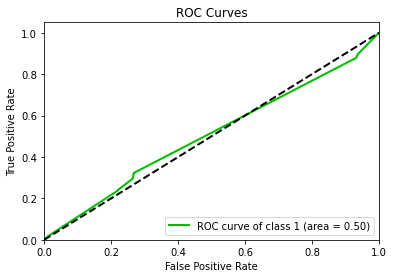

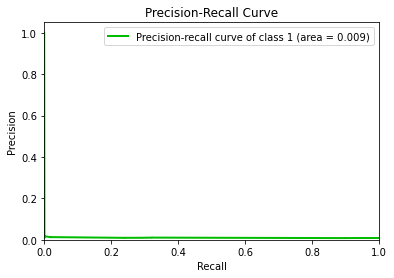

In [48]:
%time performances(classifier7, X_test, y_test,scale=True)

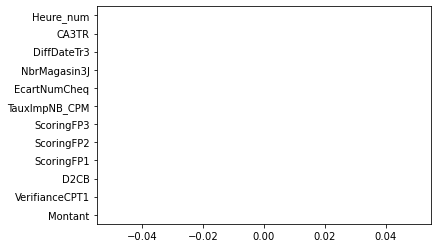

In [49]:
importances = pd.Series(AdaBoost.feature_importances_, index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances.plot(kind='barh', color='blue')
plt.show()

# B. XGradient boosting

In [50]:
# En pratique, ces arbres sont peu profonds. le paramètre par défaut est max_depth=3

from xgboost import XGBClassifier 

dtree = DecisionTreeClassifier(max_depth = 3, random_state = 0)

modele = XGBClassifier(base_estimator = dtree, n_estimators = 10, random_state = 0) 
# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data
%time classifier8 = delayed(modele.fit)(X_train, y_train).compute()

CPU times: total: 2min 39s
Wall time: 2min 36s


-------------------------------------------------------
Modèle :
 XGBClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                    random_state=0),
              n_estimators=10)
-------------------------------------------------------


C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1_score :
 0.0
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    740837
           1       0.00      0.00      0.00      6573

    accuracy                           0.99    747410
   macro avg       0.50      0.50      0.50    747410
weighted avg       0.98      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[740837      0]
 [  6573      0]]
-------------------------------------------------------
Auc Score :
 0.5
-------------------------------------------------------
Marge = -98.31 euros
-------------------------------------------------------
CPU times: total: 6.86 s
Wall time: 6.28 s


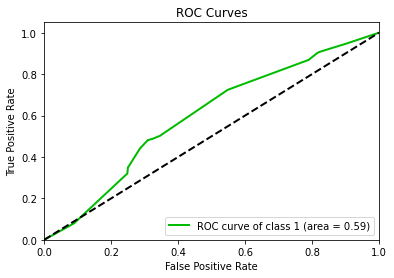

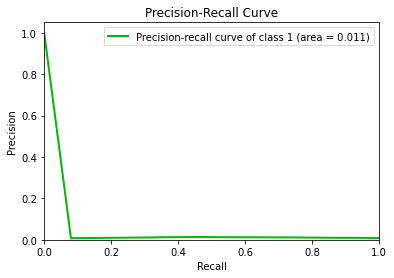

In [51]:
%time performances(classifier8, X_test, y_test,scale=True)

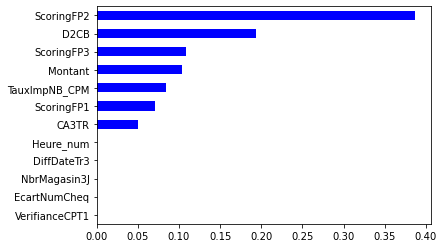

In [52]:
importances = pd.Series(modele.feature_importances_, index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances.plot(kind='barh', color='blue')
plt.show()

# C. Random forest avec bagging

In [57]:
#avec bagging #avec Adasyn
model_best= RandomForestClassifier(n_estimators = 10, random_state = 0)

modele_best =BaggingClassifier(base_estimator=model_best,n_estimators = 10, random_state = 0,n_jobs=-1)

In [58]:
# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data
%time classifier9 = delayed(model_best.fit)(X_trainS, y_trainS).compute()

CPU times: total: 6min 15s
Wall time: 6min 12s


-------------------------------------------------------
Modèle :
 RandomForestClassifier(n_estimators=10, random_state=0)
-------------------------------------------------------
F1_score :
 0.03366115204862803
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      0.96      0.98    740837
           1       0.02      0.09      0.03      6573

    accuracy                           0.95    747410
   macro avg       0.51      0.53      0.51    747410
weighted avg       0.98      0.95      0.97    747410

-------------------------------------------------------
Matrice de confusion :
 [[713120  27717]
 [  5986    587]]
-------------------------------------------------------
Auc Score :
 0.5259458216540315
-------------------------------------------------------
Marge = 1981104.1 euros
-------------------------------------------------------
CPU times: total: 8.02 s
Wall time: 7.89 s


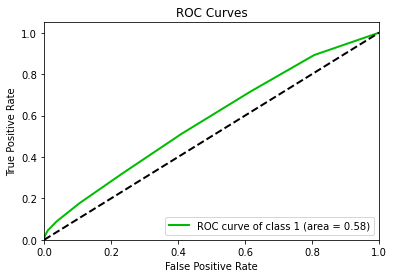

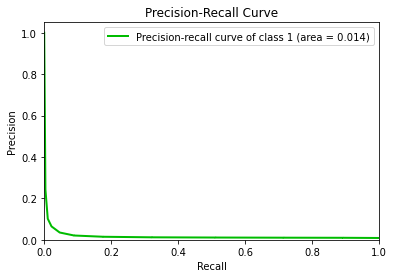

In [59]:
%time performances(classifier9, X_test, y_test,scale=True)

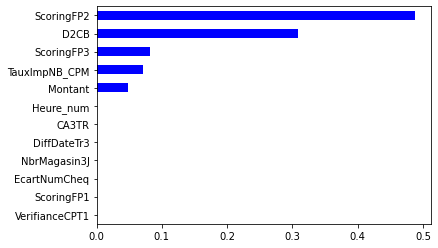

In [60]:
importances = pd.Series(modele.feature_importances_, index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances.plot(kind='barh', color='blue')
plt.show()

**Conclusions**

Pour Adaboost et XGBoost, les méthodes de recalibrage Adasyn et Bordeline SMOTE ne modifient pas drastiquement les performances. 
Adasyn paraîtrait mieux fonctionner sur le random forest... mais s'agissant d'un modèle intrinsèquement fondé sur de l'aléatoire, il est délicat de conclure. En revanche, nous observons que les variables les plus importantes de ce modèle le plus performant sont **FP2, D2CB,FPP3 et TauxImpNB_CPM** : exactement les mêmes que XGBoost a "retenu" dans le cadre de notre protocole de comparaison de l'impact de SMOTE et de XGBoost. 